In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import psyplot.project as psy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.display import display, Video
import cfgrib
import math

from ipympl.backend_nbagg import Canvas
Canvas.header_visible.default_value = False

import warnings
warnings.filterwarnings("ignore", r"\s*The on_mappable_changed")
warnings.filterwarnings("ignore", r"\s*The input coordinates")
warnings.filterwarnings("ignore", r"\s*shading=")
warnings.filterwarnings("ignore", r"\s*\[Warning by")
warnings.filterwarnings("ignore", r"\s*ShapelyDeprecationWarning")

In [2]:
f_vt_vn = 'data/lfff00010000'
f_grid  = 'data/grids/icon_grid_0001_R19B08_mch.nc'

dss = cfgrib.open_datasets(f_vt_vn, engine='cfgrib',
                        backend_kwargs={
                            'indexpath': '', 'errors': 'ignore',
                            "read_keys": ["typeOfLevel", "gridType"],
                            "filter_by_keys": {"typeOfLevel": "generalVerticalLayer"},
                        }, encode_cf=("time", "geography", "vertical"))
ds_cell = dss[0]
ds_edge = dss[1]

ds_grid = psy.open_dataset(f_grid)

In [5]:
def combine_grib_grid(file, location, grid):
    
    result = None
    if location == 'edge':
        result = file.rename({'time': 'init_time','valid_time': 'time'}
                            ).rename_dims({'values':location}
                            ).assign_coords(
                            elon=('edge', np.float32(grid.coords['elon'].values))
                            ).assign_coords(
                            elat=('edge', np.float32(grid.coords['elat'].values))
                            ).assign_coords(
                            elat_bnds=(('edge','no'), np.float32(grid.coords['elat_vertices'].values))
                            ).assign_coords(
                            elon_bnds=(('edge','no'), np.float32(grid.coords['elon_vertices'].values))
                            ).expand_dims('time')
        result.elon.attrs['standard_name']='longitude'
        result.elon.attrs['long_name']='edge longitude'
        result.elon.attrs['units']='radian'
        result.elon.attrs['bounds']='elon_bnds'
        result.elat.attrs['standard_name']='latitude'
        result.elat.attrs['long_name']='edge latitude'
        result.elat.attrs['units']='radian'
        result.elat.attrs['bounds']='elat_bnds'

    elif location == 'cell':
        result = file.rename({'time': 'init_time','valid_time': 'time'}
                            ).rename_dims({'values':location}
                            ).assign_coords(
                            clon=('cell', np.float32(grid.coords['clon'].values))
                            ).assign_coords(
                            clat=('cell', np.float32(grid.coords['clat'].values))
                            ).assign_coords(
                            clat_bnds=(('cell','vertices'), np.float32(grid.coords['clat_vertices'].values))
                            ).assign_coords(
                            clon_bnds=(('cell','vertices'), np.float32(grid.coords['clon_vertices'].values))
                            ).expand_dims('time')
        
        result.clon.attrs['standard_name']='longitude'
        result.clon.attrs['long_name']='cell longitude'
        result.clon.attrs['units']='radian'
        result.clon.attrs['bounds']='clon_bnds'
        result.clat.attrs['standard_name']='latitude'
        result.clat.attrs['long_name']='cell latitude'
        result.clat.attrs['units']='radian'
        result.clat.attrs['bounds']='clat_bnds'

    result.time.attrs['axis']='T'
    #result.generalVerticalLayer.attrs['positive']='up'
    #result.generalVerticalLayer.attrs['axis']='Z'
    
    if location == 'edge':
        result=result.assign(zonal_normal_primal_edge=grid["zonal_normal_primal_edge"])
        result=result.assign(meridional_normal_primal_edge=grid["meridional_normal_primal_edge"])
        result=result.assign(edge_system_orientation=grid["edge_system_orientation"])

        clat_ind_access = lambda x: ds_grid.coords["clat"][x-1]
        clon_ind_access = lambda x: ds_grid.coords["clon"][x-1]
        
        result.coords["elat_bnds"][:,2] = result.coords["elat_bnds"][:,1]
        result.coords["elat_bnds"][:,1] = xr.apply_ufunc(clat_ind_access, ds_grid["adjacent_cell_of_edge"][1,:])
        result.coords["elat_bnds"][:,3] = xr.apply_ufunc(clat_ind_access, ds_grid["adjacent_cell_of_edge"][0,:])
        result.coords["elon_bnds"][:,2] = result.coords["elon_bnds"][:,1]
        result.coords["elon_bnds"][:,1] = xr.apply_ufunc(clon_ind_access, ds_grid["adjacent_cell_of_edge"][1,:])
        result.coords["elon_bnds"][:,3] = xr.apply_ufunc(clon_ind_access, ds_grid["adjacent_cell_of_edge"][0,:])
        
    return result

ds_cell_combi = combine_grib_grid(ds_cell, 'cell', ds_grid)
ds_edge_combi = combine_grib_grid(ds_edge, 'edge', ds_grid)
ds_edge_combi

<xarray.Dataset>
Dimensions:                        (generalVerticalLayer: 80, time: 1,
                                    edge: 1567452, no: 4)
Coordinates:
    number                         int64 1
    init_time                      datetime64[ns] 2022-02-16
    step                           timedelta64[ns] 01:00:00
  * generalVerticalLayer           (generalVerticalLayer) float64 1.0 ... 80.0
  * time                           (time) datetime64[ns] 2022-02-16T01:00:00
    elon                           (edge) float32 0.2893 0.2896 ... 0.2421
    elat                           (edge) float32 0.7384 0.7386 ... 0.7472
    elat_bnds                      (edge, no) float32 0.7383 0.7472 ... 0.7472
    elon_bnds                      (edge, no) float32 0.2892 0.2422 ... 0.242
Dimensions without coordinates: edge, no
Data variables:
    VN                             (time, generalVerticalLayer, edge) float32 ...
    VT                             (time, generalVerticalLayer, edge) float32 ...
    zonal_normal_primal_edge       (edge) float64 ...
    meridional_normal_primal_edge  (edge) float64 ...
    edge_system_orientation        (edge) int32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Zurich

In [9]:
nx=8+1
ny=4+1
max_lon=np.max(ds_grid.coords["clon"])
min_lon=np.min(ds_grid.coords["clon"])
max_lat=np.max(ds_grid.coords["clat"])
min_lat=np.min(ds_grid.coords["clat"])
dlon=(max_lon-min_lon)/(nx-1)
dlat=(max_lat-min_lat)/(ny-1)
cg_data = np.random.random((ny, nx))
max_lon,max_lat, min_lon, min_lat

(<xarray.DataArray 'clon' ()>
 array(0.30736461),
 <xarray.DataArray 'clat' ()>
 array(0.88033287),
 <xarray.DataArray 'clon' ()>
 array(-0.0128734),
 <xarray.DataArray 'clat' ()>
 array(0.73468767))

In [22]:
ix1 = np.clip( ((ds_grid.coords["clon"] - min_lon)/dlon).astype(int),0,nx-2)
iy1 = np.clip( ((ds_grid.coords["clat"] - min_lat)/dlat).astype(int),0,ny-2)
ix2=ix1+1
iy2=iy1+1
x1=min_lon+ix1*dlon
x2=min_lon+ix2*dlon
y1=min_lat+iy1*dlat
y2=min_lat+iy2*dlat
x=ds_grid.coords["clon"]
y=ds_grid.coords["clat"]

fq11=cg_data[iy1,ix1]
fq21=cg_data[iy1,ix2]
fq12=cg_data[iy2,ix1]
fq22=cg_data[iy2,ix2]

fq = np.concatenate( (np.expand_dims(fq11, axis=1), np.expand_dims(fq12, axis=1), 
    np.expand_dims(fq21, axis=1), np.expand_dims(fq22, axis=1)), axis=1 ).reshape(len(ix1),2,2)

yvec = np.concatenate( (np.expand_dims(y2-y, axis=0), np.expand_dims(y-y1, axis=0)), axis=0)
xvec = np.concatenate( (np.expand_dims(x2-x, axis=0), np.expand_dims(x-x1, axis=0)), axis=0)

mm = np.einsum('ikh,hi->ik',fq, yvec)

res= (np.einsum('ki,ik->i', xvec, mm))/((x2-x1)*(y2-y1))

ds_cell_combi["rand_cg"] = xr.Variable(('cell'), cg_data[iy1,ix1])
ds_cell_combi.rand_cg.encoding['coordinates'] = 'clon clat'

ds_cell_combi["rand_int"] = xr.Variable(('cell'), res)
ds_cell_combi.rand_int.encoding['coordinates'] = 'clon clat'


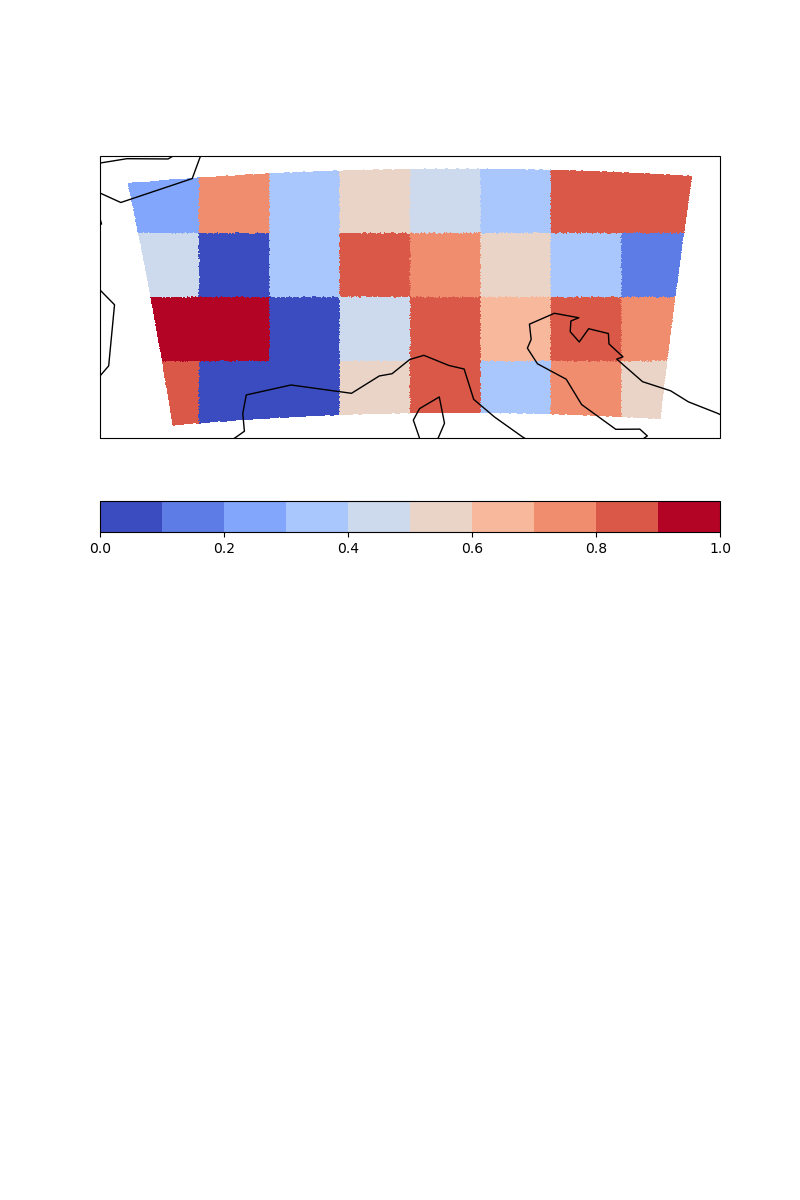

In [21]:
proj=ds_cell_combi.psy.plot.mapplot(
     name='rand_cg', 
     xgrid=None, ygrid=None, 
     datagrid=dict(c='k', lw=0.1),
     ax=(2, 1),
     cmap='coolwarm', 
     )
proj.update(datagrid=None)
     

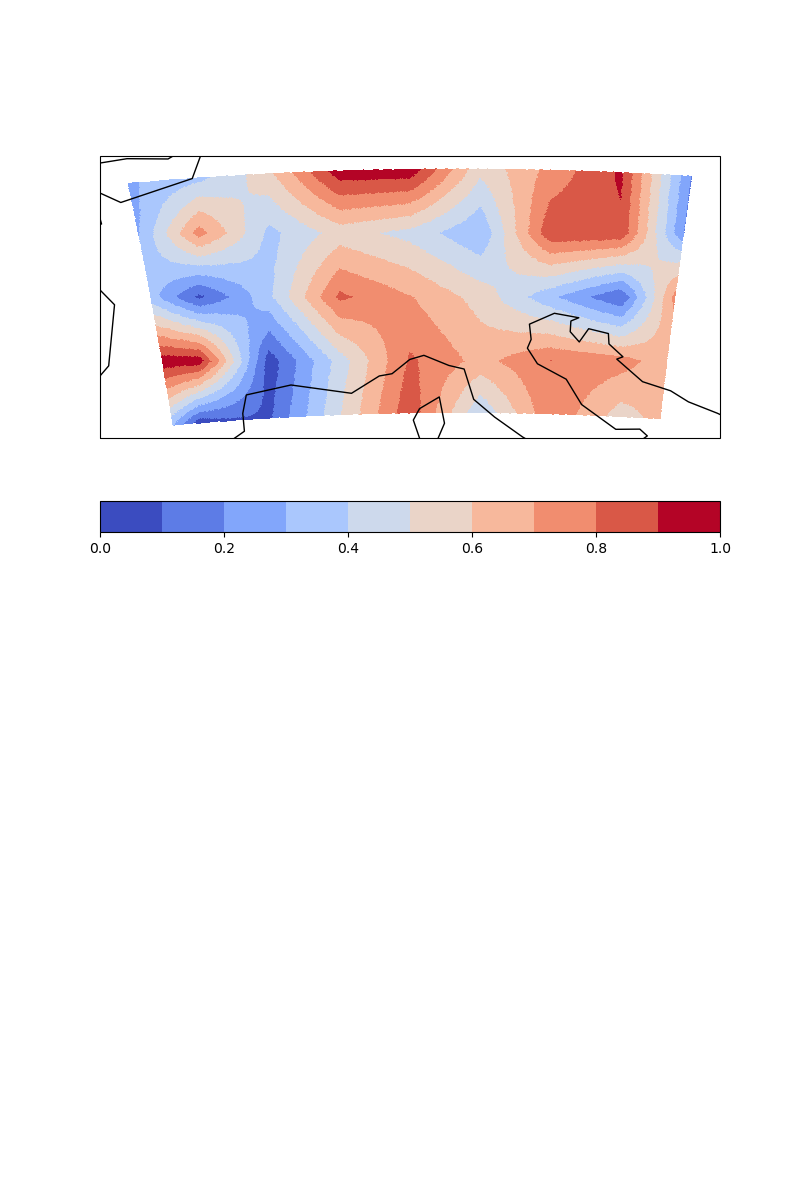

In [23]:
proj=ds_cell_combi.psy.plot.mapplot(
     name='rand_int', 
     xgrid=None, ygrid=None, 
     datagrid=dict(c='k', lw=0.1),
     ax=(2, 1),
     cmap='coolwarm', 
     )
proj.update(datagrid=None)
     